# Practice plotting

Here, we'll do some exploratory data analysis (EDA) of the pitchfx data. EDA is a quick and dirty way to determine what is in your dataset. There are many ways to do this, and plotting the data is a key way of looking at the data. Note that this is mainly practice in plotting a bunch of different types of figures.

For reference, a description of the *pitchfx* variables can be found here: https://fastballs.wordpress.com/category/pitchfx-glossary/

Begin by importing the necessary libraries and specifying a name for the database you want to create.

In [659]:
# imports
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as hier
import sklearn.decomposition as dd
import sklearn.preprocessing as pp
import sqlite3
import subprocess

# specify database name
dbname = "../dat/pitchfx2008.db"

We'll work with a subset of the dataset when performing EDA. Specifically, we will look at the pitches from a single pitcher. Here, it will be CC Sabathia.

In [5]:
# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [6]:
# get specific pitcher info
query = """SELECT DISTINCT pitchfx.* 
    FROM pitchfx
    JOIN events ON (pitchfx.game_id=events.game_id
        AND pitchfx.prev_event=events.event_id)
    WHERE events.pitcher_id=(SELECT player_id
        FROM players
        WHERE players.player_first='CC'
            AND players.player_last='Sabathia')
    ORDER BY game_id, pitch_num"""
df = pd.read_sql_query(query, db)
df.head()

,game_id,pitch_num,at_bat,time,prev_event,description,outcome,pre_balls,post_balls,pre_strike,...,vz0,ax,ay,az,break_y,break_angle,break_length,spin_dir,spin_rate,pitch_type
0,233762,3,1,NaN,0,Foul,S,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,233762,4,1,NaN,0,Called Strike,S,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,233762,5,1,NaN,0,"In play, out(s)",X,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,233762,9,2,NaN,1,Ball,B,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,233762,10,2,NaN,1,Ball,B,1,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


### Printed summaries of data

One of the first things you can do is to get a typed summary of the data set. We can do this in pandas, which has similar functions as in R. The *describe* function in pandas is similar to the *summary* function in R. Note that function only returns quantitative variables.

In [7]:
# print out summary of pandas dataframe
#df.describe()

# transpose it to see all the stats
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
game_id,3814.0,235021.241479,712.015389,233762.000,234443.00000,235024.0000,235628.00000,236174.000
pitch_num,3814.0,238.573414,148.516379,3.000,110.25000,232.0000,354.00000,605.000
at_bat,3814.0,31.030939,18.831958,1.000,14.00000,31.0000,46.00000,79.000
time,3554.0,180311.773495,28796.190986,130559.000,150133.00000,192855.5000,203255.00000,224150.000
prev_event,3814.0,40.203723,26.110433,0.000,17.00000,39.0000,59.00000,107.000
pre_balls,3814.0,0.809386,0.930079,0.000,0.00000,1.0000,1.00000,3.000
post_balls,3814.0,1.146041,1.000610,0.000,0.00000,1.0000,2.00000,4.000
pre_strike,3814.0,0.900105,0.828761,0.000,0.00000,1.0000,2.00000,3.000
post_strike,3814.0,1.314630,0.855773,0.000,1.00000,1.0000,2.00000,3.000
start_speed,3554.0,89.323663,5.805053,73.200,84.60000,92.4000,94.30000,98.900


Note that you can also look at the stats for a single feature. Here, we'll look at *spin rate*.

In [8]:
# show stats for spin rate
df['spin_rate'].describe()

count    3554.000000
mean     1931.415651
std       585.648138
min        43.628000
25%      1601.862250
50%      2028.085500
75%      2330.002250
max      3523.456000
Name: spin_rate, dtype: float64

Note that you can also store data in a different variable name and perform similar summary commands. Here, we will look at the percentiles (specifically the 0.1 and 0.5 percentile). The 50% percentile should match the median.

In [9]:
# store spin rate in a different variable
spin_rate = df["spin_rate"]
spin_rate.quantile([0.1, 0.5])

0.1    1042.3263
0.5    2028.0855
Name: spin_rate, dtype: float64

### Boxplots

Boxplots are common when visualizing quartile information. We'll stay with *spin rate* for our boxplot. Before plotting the data, we'll need to remove the nans.

Note that when extracting a single column from a dataframe, the column is now a *series* object. The series should be converted into a numpy array if plotting from matplotlib and not pandas (here we are plotting directly from a pandas object).

The red line is the median, the edges of the box are the 25% and 75% quartiles, and the the lines below and above the box correspond to some factor (*whis* in the arguments) multiplied by the interquartile range (Q3-Q1). It is meant to help identify outliers.

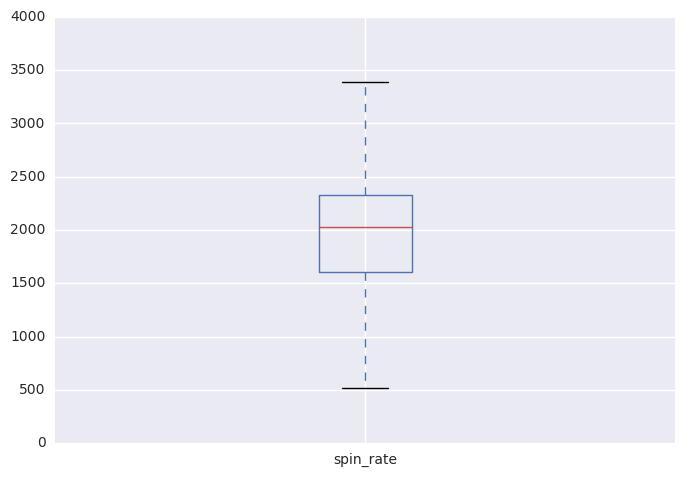

In [10]:
# remove nans
spin_rate = spin_rate.dropna()

# create boxplot
#plt.boxplot(spin_rate.as_matrix(), whis=1.5)
spin_rate.plot.box(whis=1.5)
plt.show()

Now, let's create boxplots of velocity sorted by pitch types.

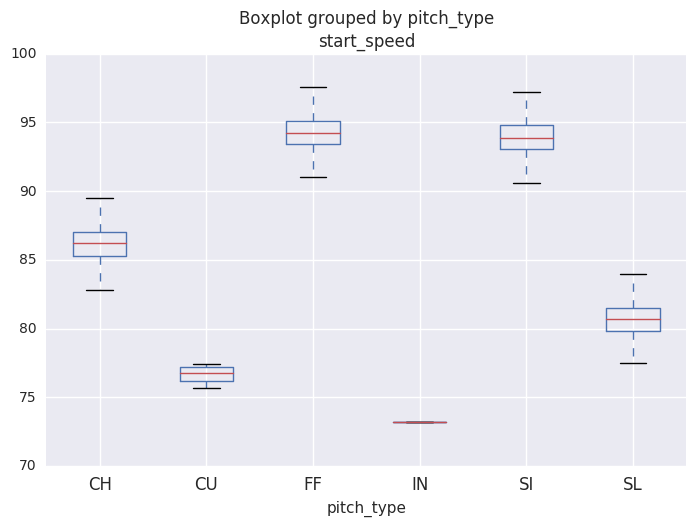

In [11]:
# create plot
df.boxplot(column="start_speed", by="pitch_type")
plt.show()

As we can see, Sabathia's fastball has the highest starting velocity, followed by his sinker, change-up, slider, and cutter.

Next, we'll look at how horizontal movement in inches (pfx_x) varies with pitch type.

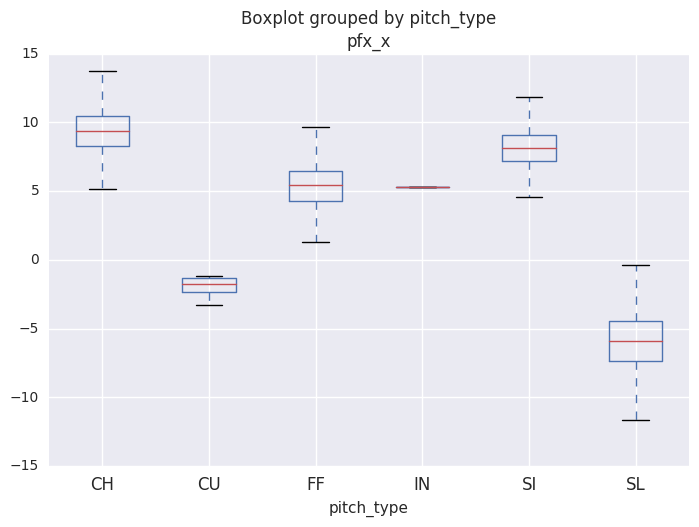

In [12]:
# create plot
df.boxplot(column="pfx_x", by="pitch_type")
plt.show()

As we can see, horizontal movement varies dramatically between sliders and changes-ups. Perhaps surprisingly, data suggests that Sabathia's slider has less horizontal movement than his change-up. It is assumed that, from the hitter's and catcher's perspective, negative values correspond to movement right to left and positive values correspond to movement left to right (based on Sabathia's handedness and the natural break of the slider).

Now let's look at vertical movement.

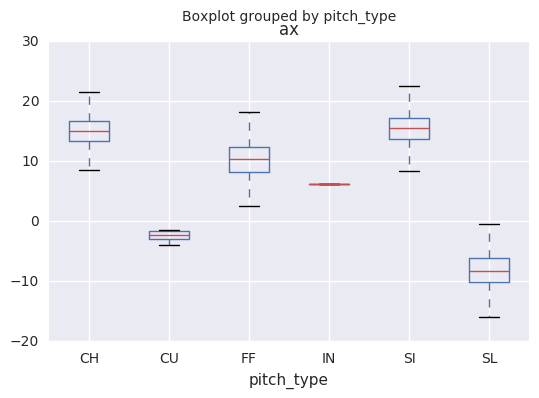

In [711]:
# create plot
df.boxplot(column="pfx_z", by="pitch_type")
plt.show()

We see that many pitches have "upward" movement, which doesn't make sense. However, given the way movement is defined, this can make sense. For example, most pitches, with curveballs being the main exception, have some backspin, which causes them not to drop as much as a spinless pitch (https://www.beyondtheboxscore.com/2009/4/17/841366/understanding-pitch-f-x-graphs). Note that again, sliders and change-ups are well separated from each other, but many pitches have positive vertical movement.

We'll look more closely at how often each of these pitches is thrown in a later section.

### Histograms

Next, we'll create a histogram of the same *spin_rate* data. We'll use *matplotlib* directly here. We'll show the effects of plotting histograms with different bin sizes side by side.

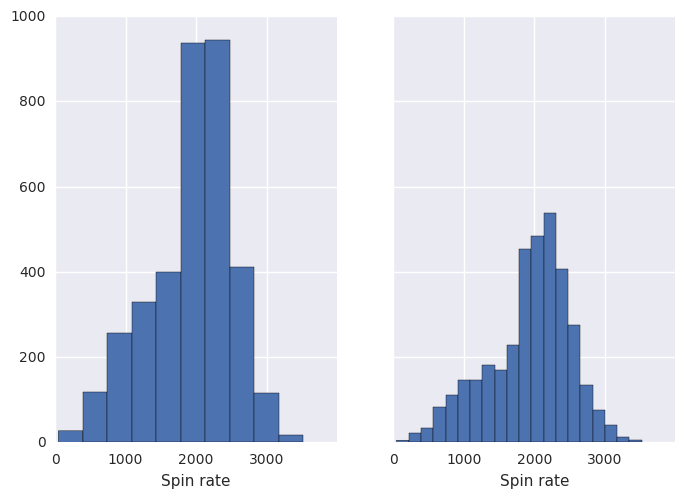

In [14]:
# convert series data to numpy array before plotting
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True) # share y-axis to show difference in values
ax1.hist(spin_rate.as_matrix())
ax1.set_xlabel("Spin rate")
ax1.set_xticks(np.arange(0, 4000, 1000)) 
ax2.hist(spin_rate.as_matrix(), bins=20)
ax2.set_xlabel("Spin rate")
ax2.set_xticks(np.arange(0, 4000, 1000)) 
plt.show()

We can also use seaborn to creat histograms with rug plots below. The rug plot is a fine-grain overview of the data, as opposed to a histogram, which bins the data. However, with so many data points the rug plot is not too useful. Note that the y-axis is normalized by default, as this is a distribution.

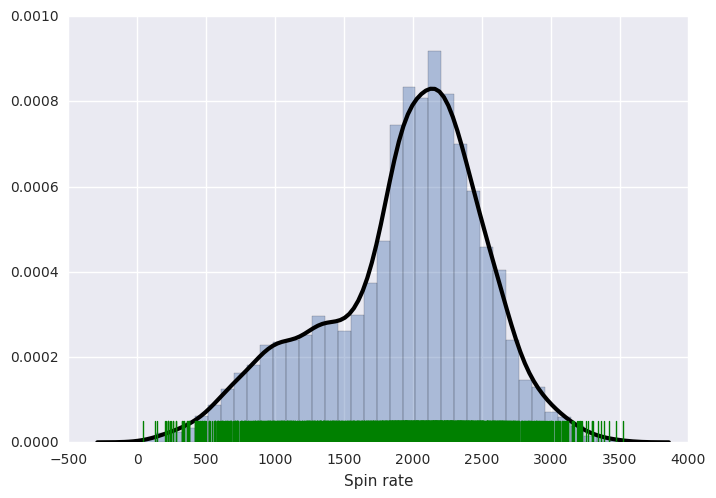

In [15]:
fig, ax = plt.subplots()
sns.distplot(spin_rate.as_matrix(), rug=True, hist=True, rug_kws={"color": "g"},
    kde_kws={"color": "k", "lw": 3})
ax.set_xlabel("Spin rate")
plt.show()

### Bar charts

We will now create a bar chart of all the pitch types thrown by CC Sabathia. First, let's get a summary of the pitch type information.

In [16]:
# describe pitch type information
df["pitch_type"].describe()

count     3554
unique       6
top         FF
freq      1489
Name: pitch_type, dtype: object

There are NaNs in the data, so let's clean them out and put them in a new variable name.

In [17]:
pitch_type = df["pitch_type"].dropna()

Next, let's create a bar plot of all the pitch types.

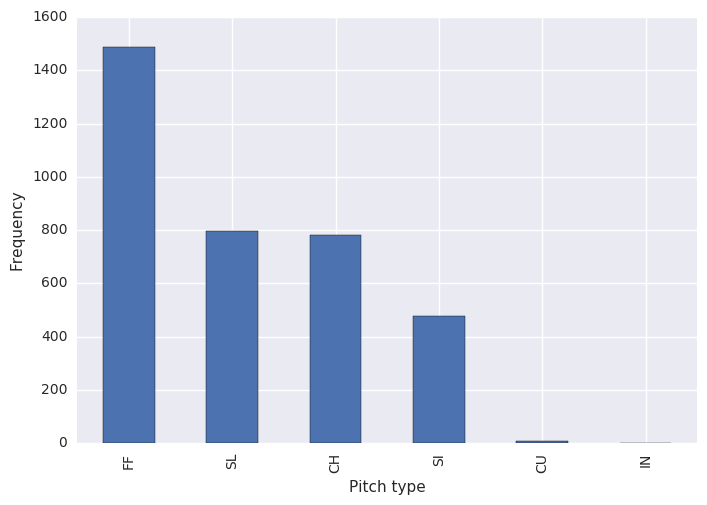

In [18]:
fig, ax = plt.subplots()
pitch_type.value_counts().plot(ax=ax, kind="bar")
ax.set_xlabel("Pitch type")
ax.set_ylabel("Frequency")
plt.show()

We can see that Sabathia complements his four-seam fastball with a slider, change-up, and sinker. There are a few pitches classified as cutters, but they are unlikely to actually be cutters given how infrequent they are throughout the season.

### Scatter plots

Here, we'll look at the raw data through scatter plots of various measurements. First, we'll pull up a summary of the pitchfx parameters that are available.

In [19]:
# get variable names from pitch fx with data types
print(*[df.dtypes], sep="\n")

game_id           int64
pitch_num         int64
at_bat            int64
time            float64
prev_event        int64
description      object
outcome          object
pre_balls         int64
post_balls        int64
pre_strike        int64
post_strike       int64
start_speed     float64
end_speed       float64
sz_top          float64
sz_bot          float64
pfx_x           float64
pfx_z           float64
px              float64
pz              float64
x               float64
y               float64
x0              float64
y0              float64
z0              float64
vx0             float64
vy0             float64
vz0             float64
ax              float64
ay              float64
az              float64
break_y         float64
break_angle     float64
break_length    float64
spin_dir        float64
spin_rate       float64
pitch_type       object
dtype: object


Most of these variables are going to be useful for classifying pitches. However, not all of them will be useful. Specifically, any variable not directly related to the trajectory of the ball. Therefore, we will chop off the first eleven variables, which have mostly to do with the times and situations at which the pitch was thrown. For a description of each of the features, have a look at:  https://fastballs.wordpress.com/category/pitchfx-glossary.

In [34]:
# create truncated pitchfx data frame
pdf = df.iloc[:, 11:].dropna()

Now we have a smaller data frame with fewer features. Let make a scatter plots of all these variables to see if there are any clear trends. Note that we will drop all rows containing NaNs to make the analysis easier. Typically where there are NaNs, it means that there was no measurment made of the pitch trajectory information. Therefore, we drop the entire row. We will also drop the last column, which is the pitch classification from MLB.

Here, we will plot all features but only 100 pitches.

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=50.0, right=50.0
  'left=%s, right=%s') % (left, right))
/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=50.0, top=50.0
  'bottom=%s, top=%s') % (bottom, top))


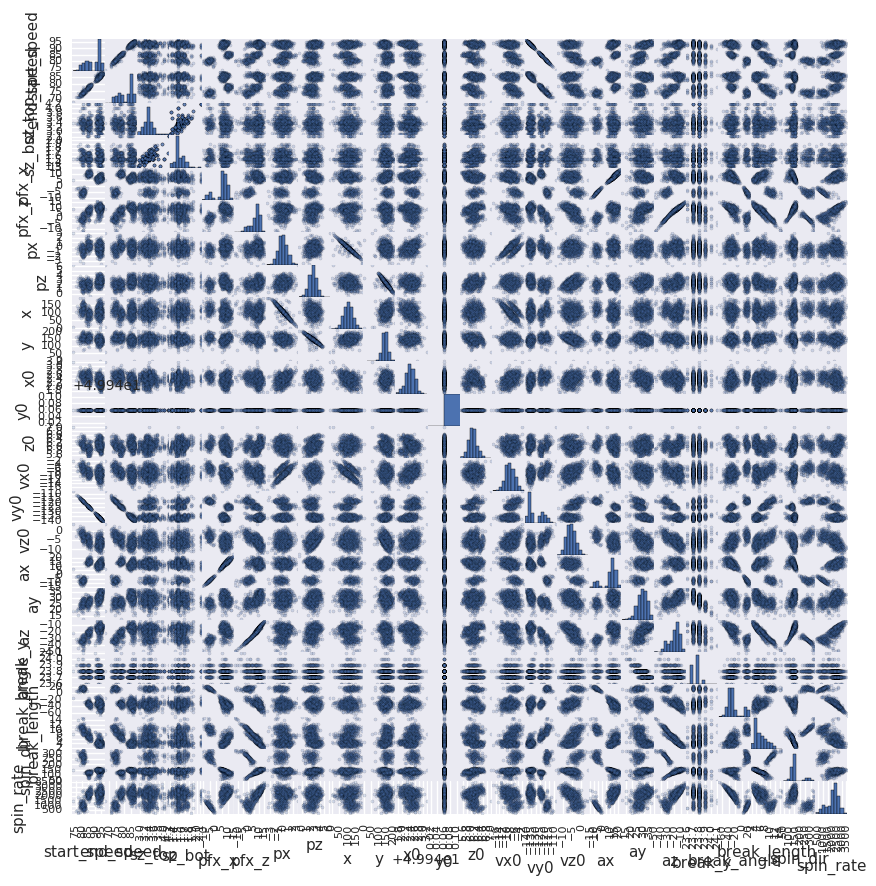

In [35]:
#pd.scatter_matrix(pdf.iloc[:100, :-1].dropna(axis=0, how='all'), alpha=0.2, figsize=(10, 10))
pd.scatter_matrix(pdf.iloc[:1000, :-1].dropna(axis=0, how='all'), alpha=0.2, figsize=(10, 10))
plt.show()

There is a lot of information in this scatter matrix, and it's difficult to pick out certain trends. However, we will try to explain some of what we see.

1) yo and break_y seem to be variables with a small spread of values. The former is the distance in feet from home plate where the PITCHf/x system is set to measure the initial parameters, and it is typically fixed after the year 2007. The latter is the distance in feet from home plate to the point in the pitch trajectory where the pitch achieved its greatest deviation from the straight line path between the release point and the front of home plate. This trait is potentially a fixed value for each game/stadium and does not appear to be very insightful.

2) There are very strong linear trends amongst certain features. Among them are x and px and y and pz. All these features are related to the location of the ball crossing the plate, with x and y tied to the old location system and px and pz related to the pitchfx system. Additionally, there seem to be strong trends between ax and pfx_x and az and pfx_z. This suggets that movement (in inches) is tied to acceleration (in ft/s), which is not surprising. Also, there is a strong correlation between start_speed and vy0, which is not surprising given that they are measuring speeds toward the plate.

3) There appears to be certain features that produce distinct clusters. For instance, start_speed and spin_rate, start_speed and pfx_x (horizontal movement), and start_speed and break_angle. These might be useful features when attempting to classify pitch types.

### Cross plots

Let's focus on some of the more interesting plots. From point number 3, it seems that useful parameters to look at are end_speed, spin_rate, and pfx_x (horizontal movement). Let's put all of these into one crossplot, with end speed (mph) and spin rate (rpm) as the axes and horizontal movement as the color.

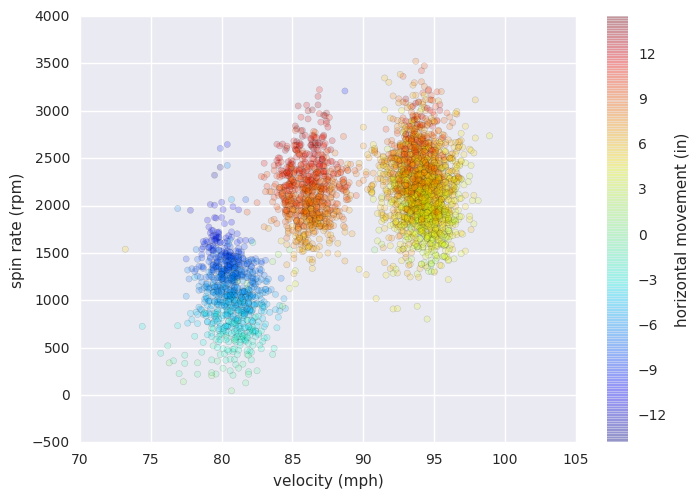

In [71]:
# crossplot of start speed and spin rate, colored by horizontal movement
plt.scatter(pdf["start_speed"], pdf['spin_rate'], c=pdf['pfx_x'], cmap="jet", alpha=0.2)
plt.xlabel("velocity (mph)")
plt.ylabel("spin rate (rpm)")
plt.colorbar(label="horizontal movement (in)")
plt.show()

There are three clear clusters!

The slowest pitch has a low spin rate and significant movement from right to left (from a left-handed pitcher), which suggests that this pitch is a slider. The second slowest cluster has a higher spin rate and velocity than the slider, and has movement from left to right, which suggests this pitch is his change-up. The third cluster appears to contain two types of pitches, based on the difference in horizontal movement. From looking at the previous bar charts of horizontal movement grouped by pitch type, the sinker has more horizontal movement than the four-seam fastball. Therefore, it looks like we could separate pitches in the third cluster with another axis.

Now let's compare our results to the given pitch classifications. We'll plot velocity against spin rate, and color by the pitch type.

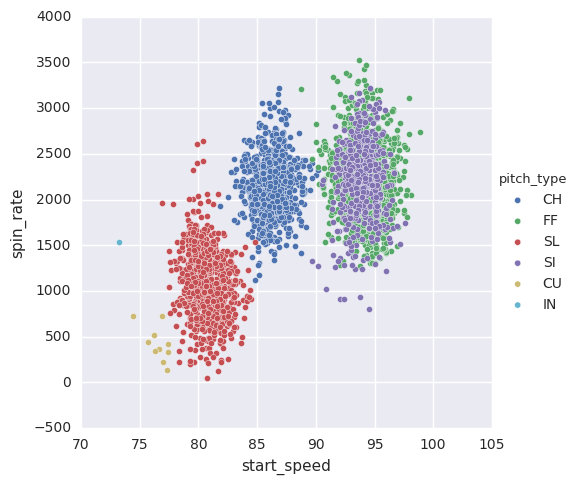

In [74]:
# crossplot of spin rate and start speed, colored by pitch type
sns.pairplot(x_vars="start_speed", y_vars="spin_rate", data=pdf, hue="pitch_type", size=5)
plt.show()

We can see that two of our classifications (slider and changeup) are separated and clustered as we had hypothesized. We can also see that the sinker and four-seam fastball are overlain on the third cluster. However, the spread in spin rate of the sinker appears greater than hypothesized in the previous crossplot.

Let's get another view of the clusters. Here, we'll switch two of the axes: spin rate and horizontal movement. We will now color by spin rate.

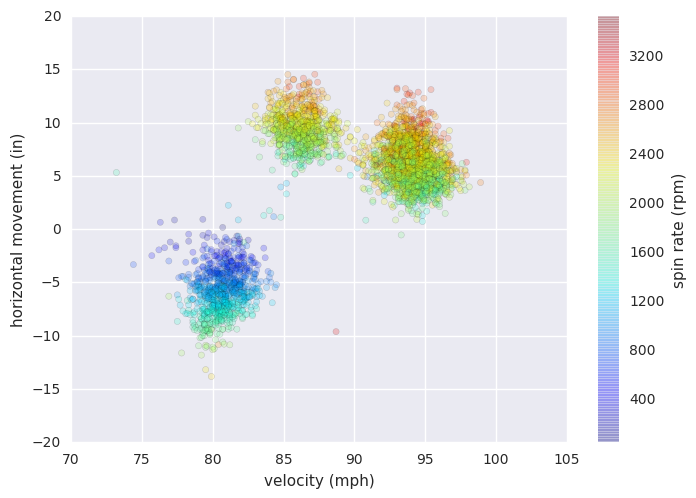

In [75]:
# crossplot of start speed and spin rate, colored by horizontal movement
plt.scatter(pdf["start_speed"], pdf['pfx_x'], c=pdf['spin_rate'], cmap="jet", alpha=0.2)
plt.xlabel("velocity (mph)")
plt.ylabel("horizontal movement (in)")
plt.colorbar(label="spin rate (rpm)")
plt.show()

It appears that the higher the spin rate, the greater the horizontal movement, which makes sense. However, it doesn't appear to separate sinkers and fastballs that clearly. We know that sinkers typically have more movement, so it's likely that the higher spin rate pitches are sinkers.

Let's plot the same scatter plot but color by the classifications from the dataset. We'll see how our hypothesis that sinkers have more spin compares to the given labels.

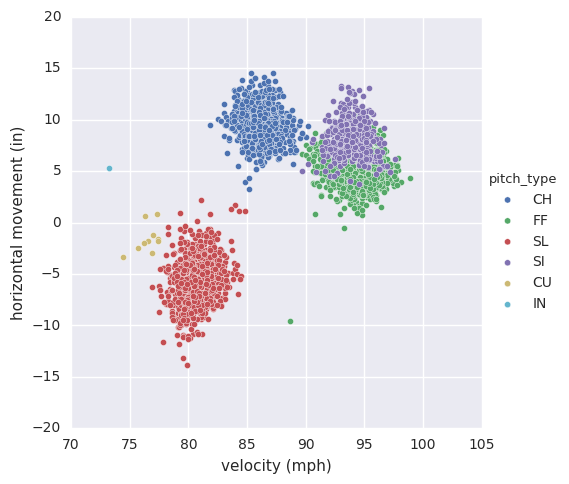

In [82]:
# crossplot of start speed and horizontal movement, colored by spin rate
sns.pairplot(x_vars="start_speed", y_vars="pfx_x", data=pdf, hue="pitch_type", size=5)
plt.xlabel("velocity (mph)")
plt.ylabel("horizontal movement (in)")
plt.show()

As we can see, the sinker has more horizontal movement compared to the four-seam fastball. Therefore, it seems like it's possible to separate the pitches given the features we have. Next, we'll perform some dimension reduction to see if we can separate these events better and to better-understand which features are important.

### Dimension reduction

Dimension reduction is a way to transform the full data set into a lower-dimension representation. We'll look at principal component analysis (PCA) here, as it is a pretty standard method.

PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. We can potentially separate these pitches in a different space, as well as infer which features are important for data separation.

As first step, we need to standardize the features. This is an important step here, as the features are very different units and have very different scales. We'll remove the means and divide by the variance of each feature. Remember to remove the categorical features here, as they won't be useful in this case. Additionally, we will remove numerical features that are just indices (e.g., pitch number and event number).

Note that an alternative to use *OneHotEncoder* to encode the categorical variables instead of dropping them (see: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder).

A note about sklearn. The pipeline is usually that you initialize your sklearn objects (e.g., standardizing variables, svm, pca, etc.). Next, you can run something like *fit*, *transform*, or *fit_transform*. *fit* means that the output is some sort of value(s). *transform* means that the output has the same dimensions as the input. Sometimes you run *fit* then *transform*, in which case you can use *fit_transform* if you don't care about saving the intermediate values.

In the case of standardizing variables, the *fit* portion is when you calculate the mean and standard deviations of the features. The *transform* portion is the actual standardization of the features.

In [487]:
# remove categorical variables
pfx_vals = df.drop(df.dtypes.index[df.dtypes.values == "object"], 1).dropna()

# remove indexing variables
pfx_vals = pfx_vals.drop(["game_id",
                          "pitch_num",
                          "at_bat",
                          "time",
                          "prev_event"], axis=1)

## this is how to standardize the variables in two steps
## standardize the features
#stand = pp.StandardScaler()
#pfx_std = stand.fit(pfx_vals)
#
## now standardize the features
#pfx_vals_std = pfx_std.transform(pfx_vals)

# this is how to standardize the variables in one step
stand = pp.StandardScaler()
pfx_vals_std = stand.fit_transform(pfx_vals)

Now let's run some PCA now that the features are standardized. We will only use *fit* here, as we're interested in looking at the principal components and the explained variance ratios. Note that we are also turning *whiten* on, so components_ vectors are multiplied by the square root of n_samples and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances. Whitening will remove some information from the transformed signal (the relative variance scales of the components) but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some hard-wired assumptions.

In [488]:
# create pca
pca = dd.PCA(whiten=False)

# run pca in two steps
pfx_pca = pca.fit(pfx_vals_std)

Let's plot the percent of variance explained by each principal component and the cumulative sum of the variance explained on the same plot. This type of plot can help determine how many principal components to keep for data compression or how much variance can be explained when visualizing the data.

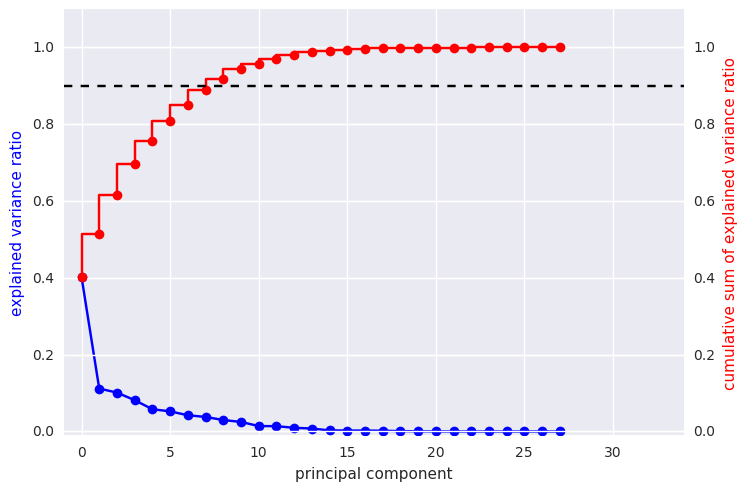

In [489]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(pfx_pca.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(pfx_pca.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 34])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

There are a few observations we can make. First, note that we've added a black horizontal dashed line at 90% of the data variance explained. We can see that we can explain 90% of variance in the data with just 8 principal components (as opposed to the full 33 components). Therefore, we can greatly compress the size of our data set if we are willing to be unable to explain 10% of the variance. Second, there is a clear "elbow" after the first principal component in our portion of variance explained plot. In other words, while the first principal component only explains roughly 40% of the variance in the data, further principal components do not explain a substantial amount of variance in the data. Therefore, nearly half the variance in the data is explained by the first two principal components, which is useful to know for visualizing our data in 2D.

So, let's plot our data's PCA scores over the first two principal components, colored by the third principal component.

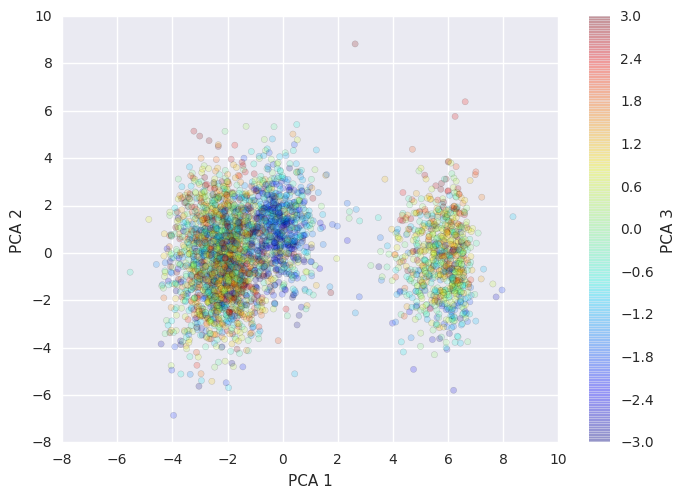

In [491]:
# transform the data into pca space
pfx_pca_trans = pfx_pca.transform(pfx_vals_std)

# plot in pca space
plt.scatter(pfx_pca_trans[:, 0], pfx_pca_trans[:, 1], c=pfx_pca_trans[:, 2], 
            cmap="jet", alpha=0.2)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="PCA 3")
plt.clim(-3, 3)
plt.show()

As we can see, there is a clear separation along the first principal component into two clusters. This trend of two clusters explains why the first principal component already explains 40% of the variance in the data. The second principal component shows relatively less variation along its axis, and the third (color) less than that. It appears that there is not much clear information about different types of pitches here (thought a third cluster might be interpretable in the figure).

Note that we can get the PCA transforms ourselves without having to use the *transform* feature. We can get the same result by multiplying the original scaled features by the components matrix. For instance, we can get the first principal component projects using the code below.

In [492]:
# first principal component
loadings1 = pfx_pca.components_[0, :]
print(np.dot(pfx_vals_std, loadings1))
print(pfx_pca_trans[:, 0])

[-0.62616363 -0.73577607 -3.38638723 ..., -1.61489446  0.73261979
  0.01147486]
[-0.62616363 -0.73577607 -3.38638723 ..., -1.61489446  0.73261979
  0.01147486]


Let's again plot the first two principal components, but color by the labeled pitches from the database.

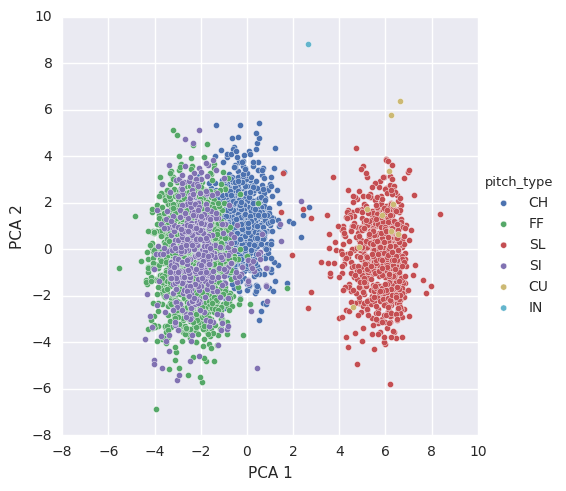

In [569]:
# create dataframe for plotting
df_pca = pd.DataFrame({"pca1":pfx_pca_trans[:, 0], "pca2":pfx_pca_trans[:, 1], "pitch_type":np.array(pdf.pitch_type)}, )

# plot in pca space, colored by pitch type from database
sns.pairplot(x_vars="pca1", y_vars="pca2", data=df_pca, hue="pitch_type", size=5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Here, we see that the sliders are the easiest pitch to separate, as they are clearly in their own cluster. However, we see that the rest of the three pitches are grouped into one cluster (changeup, sinker, fastball). These three pitches are spread simiarly along the second principal component axis. Therefore, PCA doesn't seem to be helping to separate pitches much here.

Let's take a closer look at which features the principal components are extracting at the "most important" in terms of variance. To find the most important variables in terms of their contributions to the principal component, we will look at loadings. Loadings are the projections of the principal components onto your variables. A particularly high (or particularly low) loading for a specific variable means that principal component is intimately related to the variable

We'll do this by looking for the largest values in the first principal component (first row of the component matrix here), and then the second principal component. Note that the components matrix has the shape (n_components, n_features). A biplot would be useful here... Instead, we use plot bar charts of the loadings and inspect important features manually.

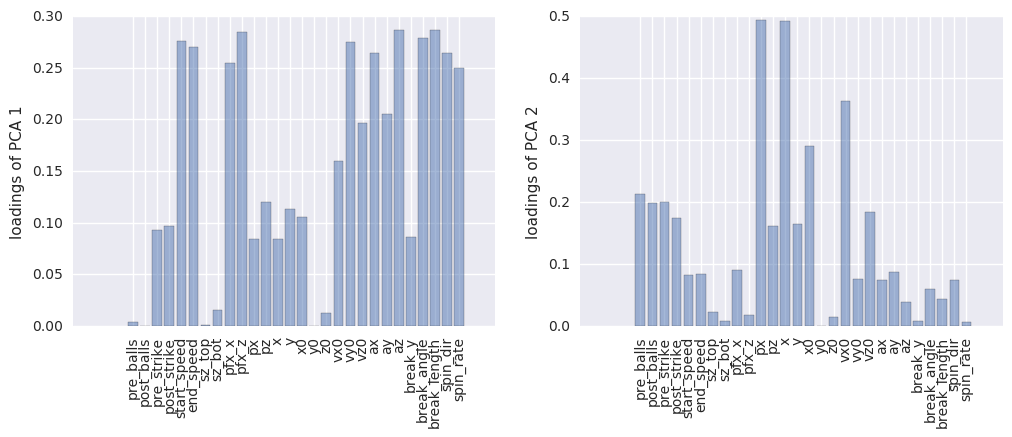

In [626]:
# first principal component
loadings1 = pfx_pca.components_[0, :]

# intialize figure
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# plot barchart of loadings1
ax[0].bar(range(pfx_vals.shape[1]), np.abs(loadings1), align='center', alpha=0.5)
ax[0].set_ylabel("loadings of PCA 1")
plt.sca(ax[0])
plt.xticks(range(pfx_vals.shape[1]), list(pfx_vals), rotation=90)

# second principal component
loadings2 = pfx_pca.components_[1, :]

# plot barchart of loadings1
ax[1].bar(range(pfx_vals.shape[1]), np.abs(loadings2), align='center', alpha=0.5)
ax[1].set_ylabel("loadings of PCA 2")
plt.sca(ax[1])
plt.xticks(range(pfx_vals.shape[1]), list(pfx_vals), rotation=90)
plt.show()

Let's focus on the first principal component first (left). We see that many of the features that relate to the ball trajectory (e.g., velocity, break length/angle, acceleration, movement) appear to be the most important features for the first principal component. From our previous analysis, we know that we can obtain relatively clear clusters plotting only these parameters.

Looking at the second principal component (right), it seems that the most important features are related to mostly the location of the pitches. While this is useful information, it is unlike to be much use in classifying pitches.

We will do some further "cleaning" of the data to tailor to the goal of pitch clustering. Specifically, we will remove all features that do not contribute to ball trajectory (i.e., pitch locations) and see what we get.

In [822]:
# remove unimportant features
pfx_vals_clean = pfx_vals.drop(["pre_balls",
                                "post_balls",
                                "pre_strike",
                                "post_strike",
                                "sz_top",
                                "sz_bot",
                                "x",
                                "y",
                                "px",
                                "pz",
                                "x0",
                                "y0",
                                "z0",
                                "break_y"], axis=1)

# standardize data
pfx_vals_std_clean = stand.fit_transform(pfx_vals_clean)

Now let's look at PCA again with the new cleaned data.

In [823]:
# create pca
pca_clean = dd.PCA(whiten=False)

# run pca in two steps
pfx_pca_clean = pca_clean.fit(pfx_vals_std_clean)

As before, let's plot the percent of variance explained by each principal component and the cumulative sum of the variance explained on the same plot.

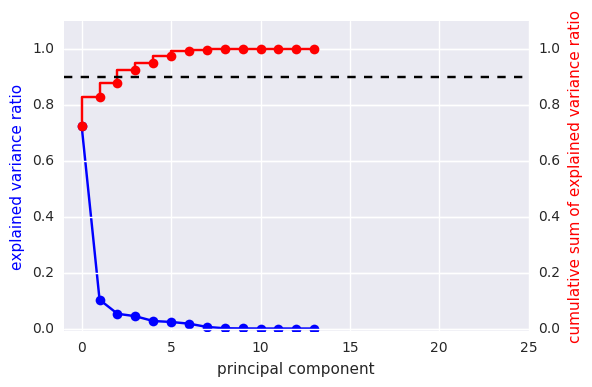

In [824]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(pfx_pca_clean.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(pfx_pca_clean.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 25])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

We can see that the first principal component already explains 70% of the variance in the dataset.

Let's plot the PCA scores again for the first three principal components.

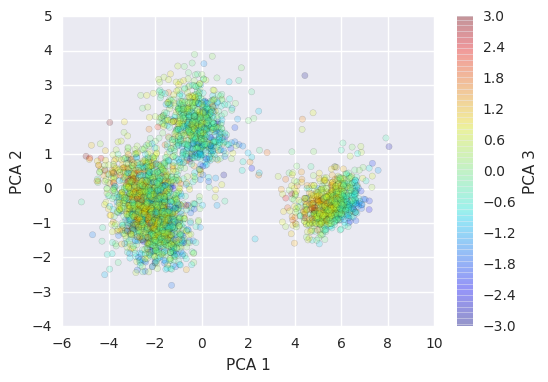

In [825]:
# transform the data into pca space
pfx_pca_trans_clean = pfx_pca_clean.transform(pfx_vals_std_clean)

# plot in pca space
plt.scatter(pfx_pca_trans_clean[:, 0], pfx_pca_trans_clean[:, 1], c=pfx_pca_trans_clean[:, 2],
            cmap="jet", alpha=0.2)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="PCA 3")
plt.clim(-3, 3)
plt.show()

We see that the data is well separated along the first principal component but not as well along the second principal component, as expected.

Again, let's plot the first two principal components, but color by the labeled pitches from the database.

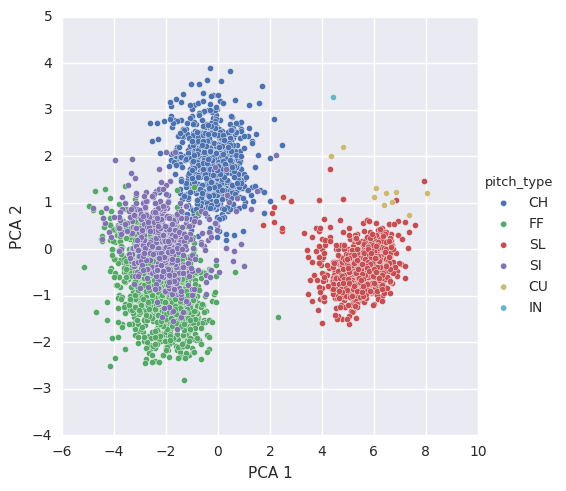

In [826]:
# create dataframe for plotting
df_pca = pd.DataFrame({"pca1":pfx_pca_trans_clean[:, 0], "pca2":pfx_pca_trans_clean[:, 1], "pitch_type":np.array(pdf.pitch_type)}, )

# plot in pca space, colored by pitch type from database
sns.pairplot(x_vars="pca1", y_vars="pca2", data=df_pca, hue="pitch_type", size=5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Again, the sliders are well-separated but the other three pitches are not.

Again, let's look at the loadings of the first two principal components to get a sense of which features might be significant.

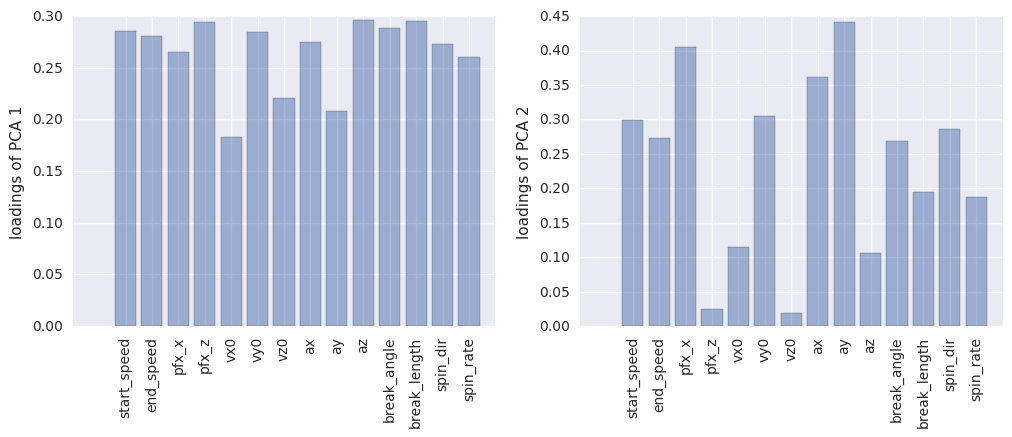

In [827]:
# initialize figure
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# first principal component
loadings1 = pfx_pca_clean.components_[0, :]

# plot barchart of loadings1
ax[0].bar(range(pfx_vals_clean.shape[1]), np.abs(loadings1), align='center', alpha=0.5)
ax[0].set_ylabel("loadings of PCA 1")
plt.sca(ax[0])
plt.xticks(range(pfx_vals_clean.shape[1]), list(pfx_vals_clean), rotation=90)

# second principal component
loadings2 = pfx_pca_clean.components_[1, :]

# plot barchart of loadings1
ax[1].bar(range(pfx_vals_clean.shape[1]), np.abs(loadings2), align='center', alpha=0.5)
ax[1].set_ylabel("loadings of PCA 2")
plt.sca(ax[1])
plt.xticks(range(pfx_vals_clean.shape[1]), list(pfx_vals_clean), rotation=90)

plt.show()

Let's also look at the loadings for the third and fourth principal components.

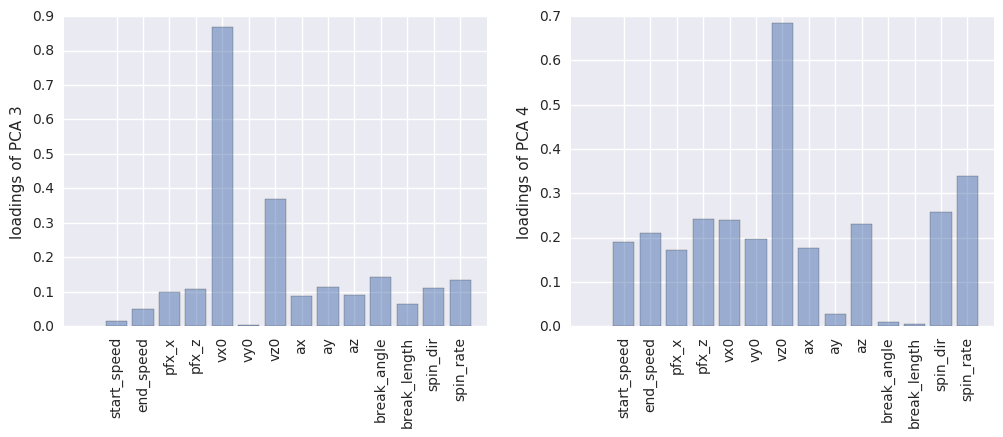

In [828]:
# initialize figure
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# first principal component
loadings3 = pfx_pca_clean.components_[2, :]

# plot barchart of loadings1
ax[0].bar(range(pfx_vals_clean.shape[1]), np.abs(loadings3), align='center', alpha=0.5)
ax[0].set_ylabel("loadings of PCA 3")
plt.sca(ax[0])
plt.xticks(range(pfx_vals_clean.shape[1]), list(pfx_vals_clean), rotation=90)

# second principal component
loadings4 = pfx_pca_clean.components_[3, :]

# plot barchart of loadings1
ax[1].bar(range(pfx_vals_clean.shape[1]), np.abs(loadings4), align='center', alpha=0.5)
ax[1].set_ylabel("loadings of PCA 4")
plt.sca(ax[1])
plt.xticks(range(pfx_vals_clean.shape[1]), list(pfx_vals_clean), rotation=90)

plt.show()

From these plots, we see that all features have similar loadings along the first principal component. This suggests that most of our features display similar variance. We also see that the third principal component corresponds roughly to intial velocity in the horizontal direction, and it does not provide much insight into pitch type separation. A biplot could help determine how much these features are correlated to each other.

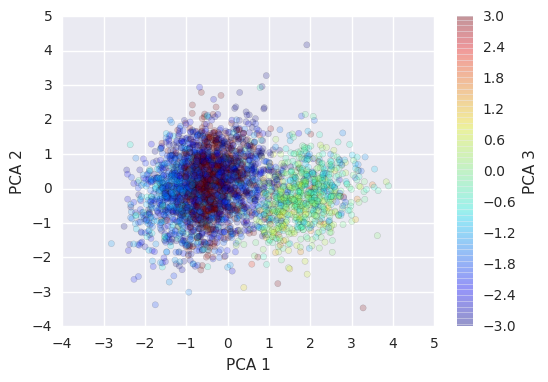

In [829]:
# transform the data into pca space
pfx_pca_trans_clean = pfx_pca_clean.transform(pfx_vals_std_clean)

# plot in pca space
plt.scatter(pfx_pca_trans_clean[:, 1],
            pfx_pca_trans_clean[:, 2],
            c=pfx_pca_trans_clean[:, 0],
            cmap="jet", alpha=0.2)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="PCA 3")
plt.clim(-3, 3)
plt.show()

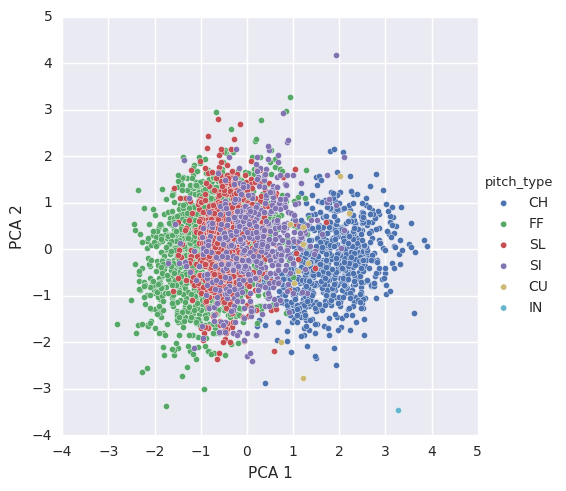

In [830]:
# create dataframe for plotting
df_pca = pd.DataFrame({"pca1":pfx_pca_trans_clean[:, 1],
                       "pca2":pfx_pca_trans_clean[:, 2],
                       "pitch_type":np.array(pdf.pitch_type)}, )

# plot in pca space, colored by pitch type from database
sns.pairplot(x_vars="pca1", y_vars="pca2", data=df_pca, hue="pitch_type", size=5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [646]:
# remove unimportant features
pfx_vals_vclean = pfx_vals[["pfx_x",
                            "pfx_z",
                            "vy0",
                            "spin_rate",
                            "start_speed"]]

# standardize data
pfx_vals_std_vclean = stand.fit_transform(pfx_vals_vclean)

In [647]:
# create pca
pca_vclean = dd.PCA(whiten=False)

# run pca in two steps
pfx_pca_vclean = pca_vclean.fit(pfx_vals_std_vclean)

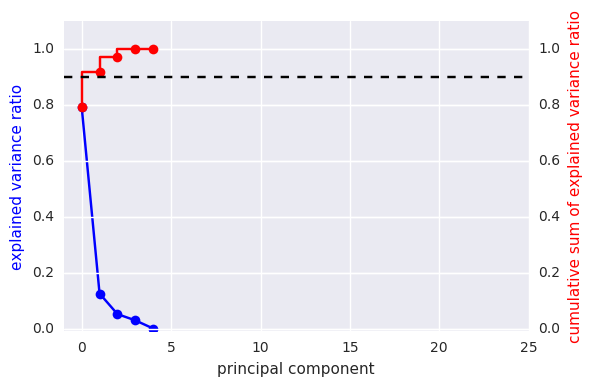

In [648]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(pfx_pca_vclean.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(pfx_pca_vclean.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 25])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

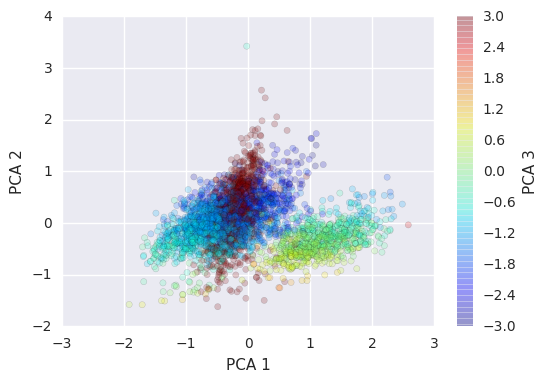

In [655]:
# transform the data into pca space
pfx_pca_trans_vclean = pfx_pca_vclean.transform(pfx_vals_std_vclean)

# plot in pca space
plt.scatter(pfx_pca_trans_vclean[:, 1],
            pfx_pca_trans_vclean[:, 2],
            c=pfx_pca_trans_vclean[:, 0],
            cmap="jet", alpha=0.2)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="PCA 3")
plt.clim(-3, 3)
plt.show()

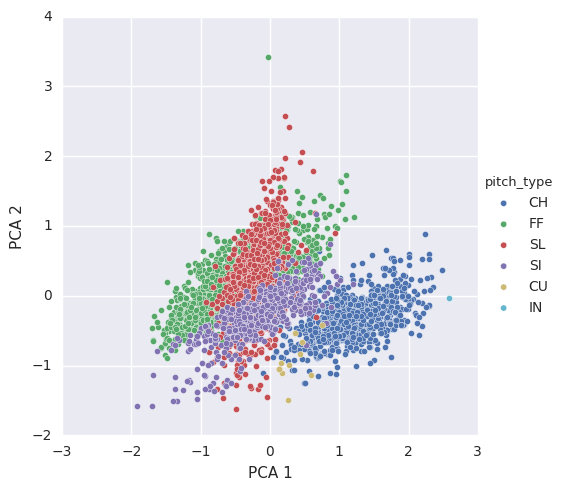

In [658]:
# create dataframe for plotting
df_pca = pd.DataFrame({"pca1":pfx_pca_trans_vclean[:, 1],
                       "pca2":pfx_pca_trans_vclean[:, 2],
                       "pitch_type":np.array(pdf.pitch_type)}, )

# plot in pca space, colored by pitch type from database
sns.pairplot(x_vars="pca1", y_vars="pca2", data=df_pca, hue="pitch_type", size=5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

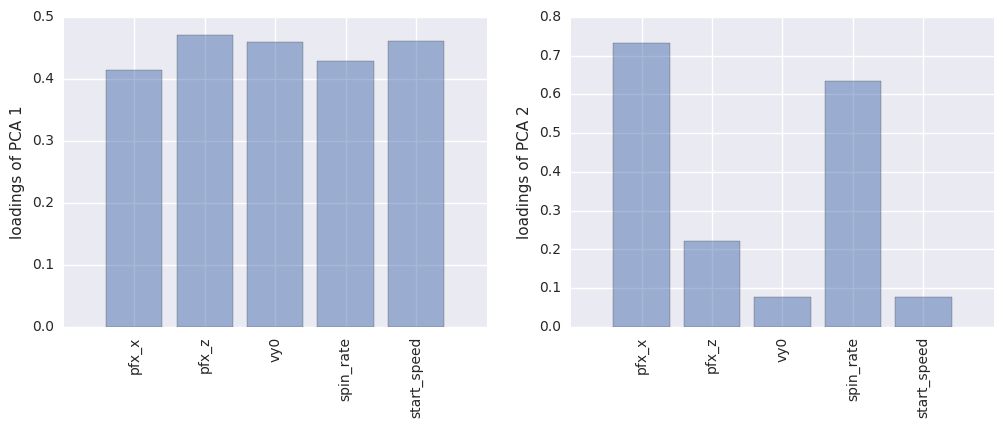

In [654]:
# first principal component
loadings1 = pfx_pca_vclean.components_[0, :]

# intialize figure
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# plot barchart of loadings1
ax[0].bar(range(pfx_vals_vclean.shape[1]), np.abs(loadings1), align='center', alpha=0.5)
ax[0].set_ylabel("loadings of PCA 1")
plt.sca(ax[0])
plt.xticks(range(pfx_vals_vclean.shape[1]), list(pfx_vals_vclean), rotation=90)

# second principal component
loadings2 = pfx_pca_vclean.components_[1, :]

# plot barchart of loadings1
ax[1].bar(range(pfx_vals_vclean.shape[1]), np.abs(loadings2), align='center', alpha=0.5)
ax[1].set_ylabel("loadings of PCA 2")
plt.sca(ax[1])
plt.xticks(range(pfx_vals_vclean.shape[1]), list(pfx_vals_vclean), rotation=90)
plt.show()

Overall, we see that PCA does not seem to be able to separate pitch clusters more clearly. We still see three clusters for the most part, with the troublesome spot being the difference between the four-seam fastball (FF) and the sinker (SI).

### Hierarchical clustering

We'll perform hierarchical clustering here to try to group the data. We start with hierarchical clustering because it is useful when there is no prior knowledge of the number of clusters (although that isn't exactly the case here). We will look at bottom-up clustering here. All data points begin as their own cluster, in some ways. Then we fuse data points together that are similar to each other, and continue until all data points are in one cluster.

There are some controls over how clusters are fused. There are four common types of linkage (complete, average, single, centroid). There are also dissimilarity measures, such as Euclidean distance and correlation-based distances. For the case of pitch classification, we will start for Euclidean distance, as we're looking for feature values with similar values.

We will use scipy for this sort of clustering. We will perform hierarchical clustering with complete linkage and euclidean distances using the data with trajectory information only.

In [831]:
# generate the linkage matrix
Zc = hier.linkage(pfx_vals_std_clean, method='complete', metric='euclidean')

Let's try to plot a dendrogram.

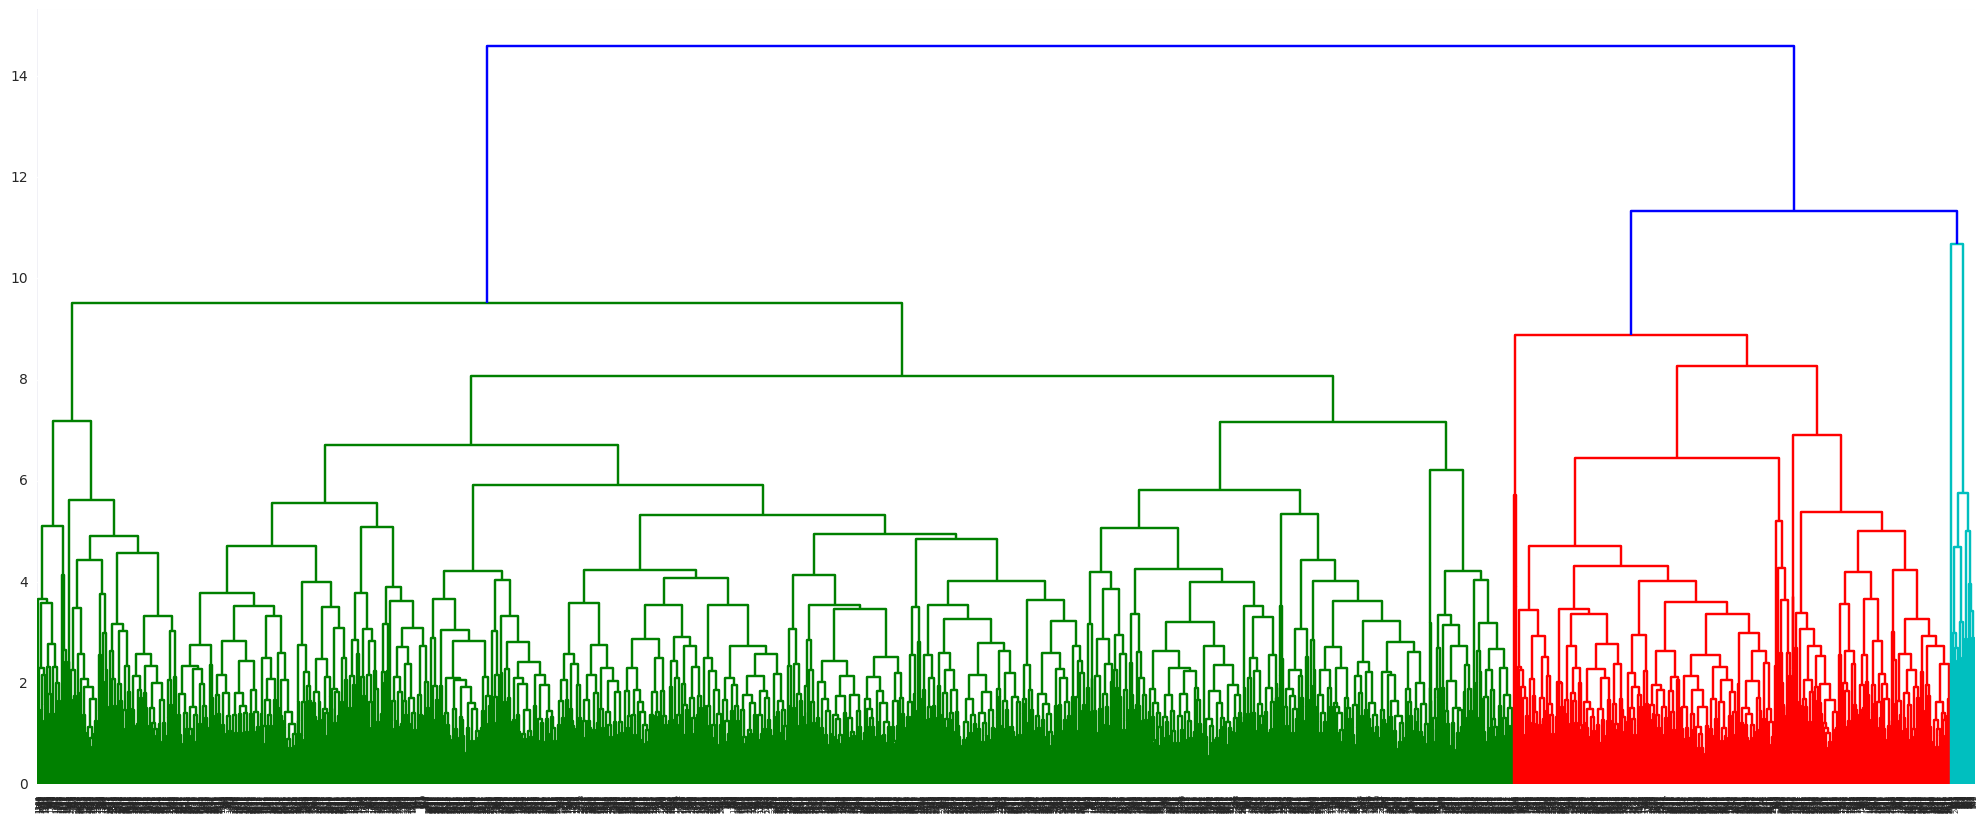

In [833]:
# plot the dendrogram colored by a certain height
heightc = 11
fig = plt.figure(figsize=(25, 10))
dn = hier.dendrogram(Zc, color_threshold=heightc, leaf_rotation=90)

As we can see, there appears to be three to hour natural clusters when using complete linkage (we highlighted three here). However, one of the clusters is relative small and leads to an unbalanced tree. Let's see what these clusters correspond to on a plot of starting speed vs horizontal movement.

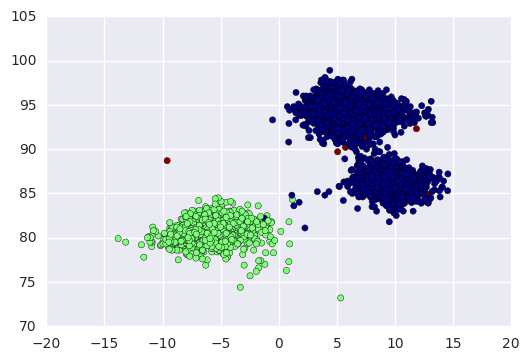

In [834]:
# labels
label = hier.fcluster(Zc, heightc,'distance')

# values for plot
hor_mv = pfx_vals_vclean["pfx_x"]
speed = pfx_vals_vclean["start_speed"]

# project label onto data points
plt.scatter(hor_mv, speed, c=label, cmap="jet")
plt.show()

We can see that complete linkage doesn't do a very good job here of clustering, as two seemingly obvious clusters are grouped together into one. Let's try ward linkage now to see if we can obtain a more balanced tree.

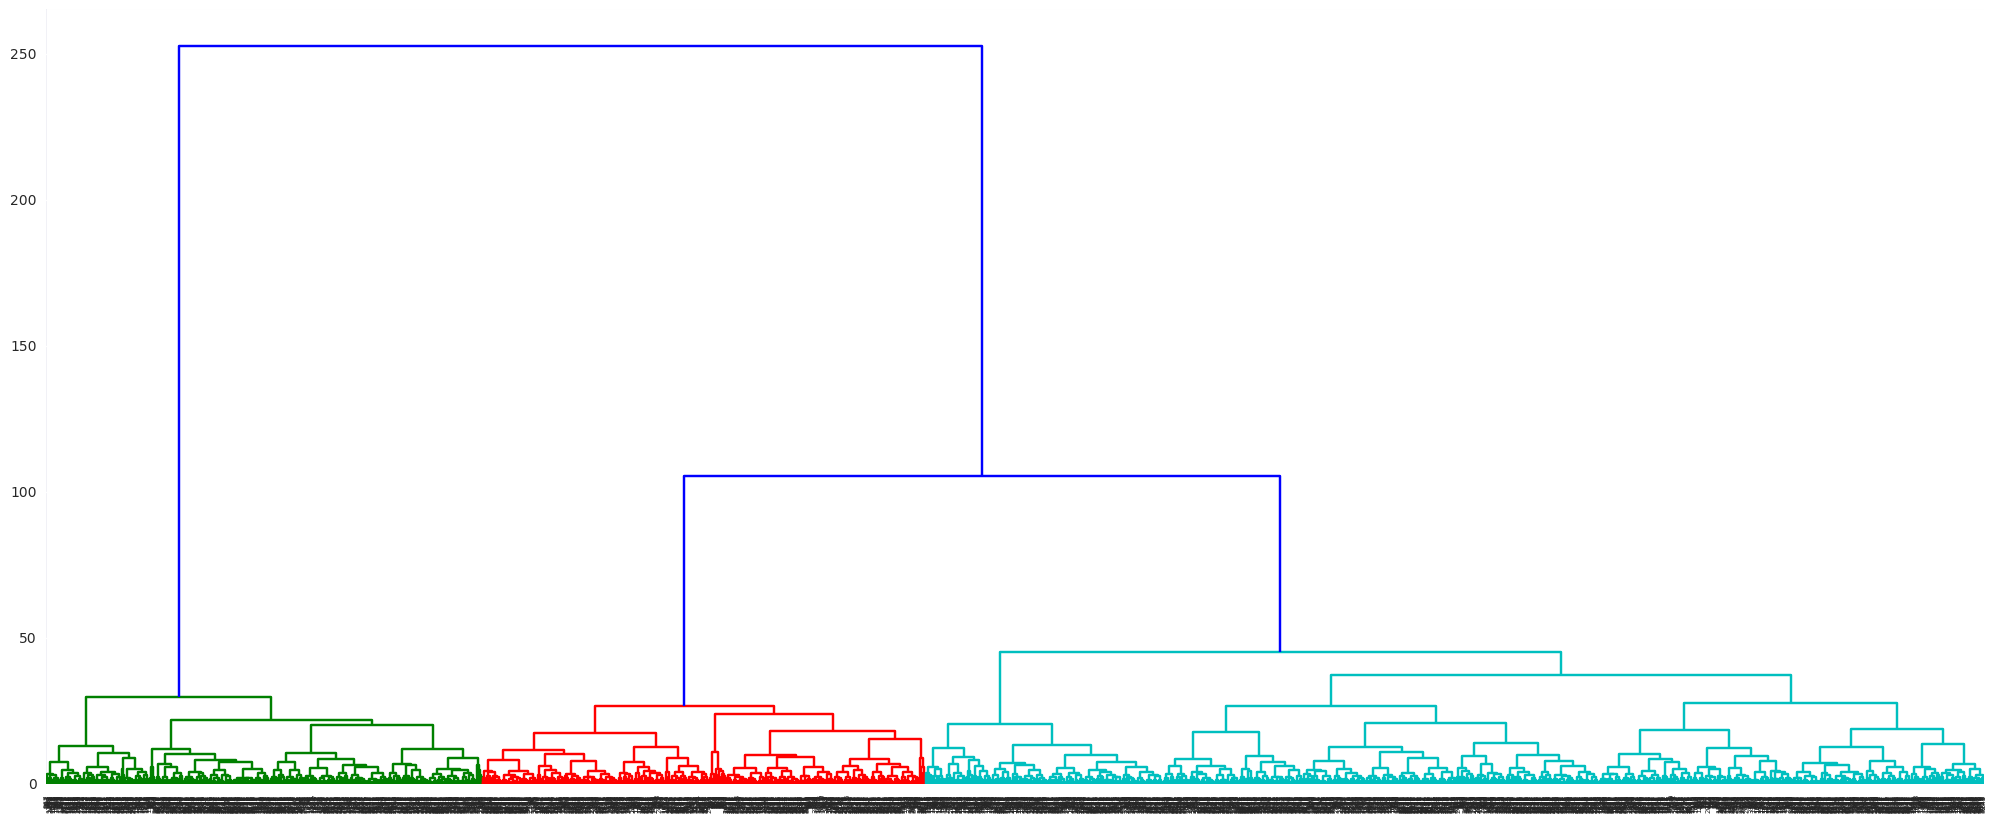

In [837]:
# generate the linkage matrix
Zw = hier.linkage(pfx_vals_std_clean, method='ward', metric='euclidean')
# plot the dendrogram colored by a certain height
heightw = 60
fig = plt.figure(figsize=(25, 10))
dn = hier.dendrogram(Zw, color_threshold=heightw, leaf_rotation=90)

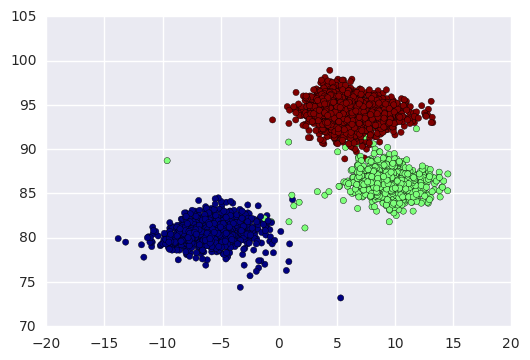

In [840]:
# labels
label = hier.fcluster(Zw, 50,'distance')

# values for plot
hor_mv = pfx_vals_vclean["pfx_x"]
speed = pfx_vals_vclean["start_speed"]

# project label onto data points
plt.scatter(hor_mv, speed, c=label, cmap="jet")
plt.show()

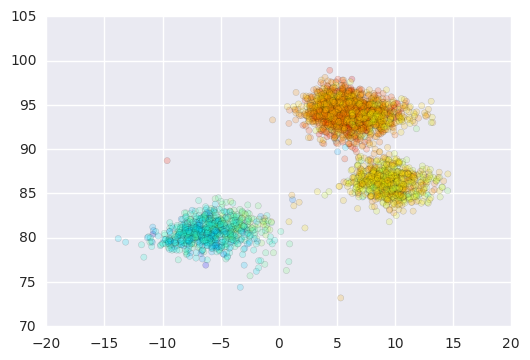

In [715]:
plt.scatter(pfx_vals["pfx_x"], pfx_vals["start_speed"], c=pfx_vals["pfx_z"], cmap="jet", alpha=0.2)
plt.show()

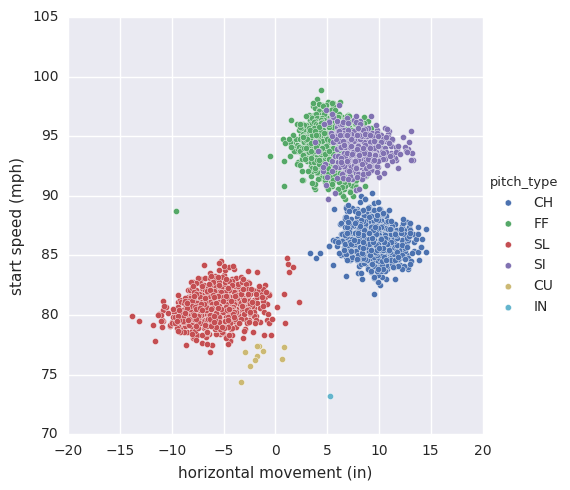

In [692]:
# plot in pca space, colored by pitch type from database
sns.pairplot(x_vars="pfx_x", y_vars="start_speed", data=df, hue="pitch_type", size=5)
plt.xlabel("horizontal movement (in)")
plt.ylabel("start speed (mph)")
plt.show()